In [27]:
import sys
import os
sys.path.append("modules")
from ukf_ex1 import *
from ukf_ex2 import *

## UKF Aggregate Critique.

In this notebook we discuss the failure of the unscented kalman filter (ukf) to perform under a certain aggregate case. The aim is to not observed agents directly, but rather count how many lie within a certain grid square and calibrate our agent based model stationsim solely using these aggregates. !! grid square heatmap plot

We vary the width of the squares, dubbed `bin_size`, and expect that as the width approaches zero we have agents in squares small enough that we can approximate their true positions very well. However, this is not the case and we see that as we vary bin_size the overall prediction error of the ukf stays roughly constant. The aim of this notebook is to try and determine why the ukf is not working as intended here and propose any potential solutons. !! aggregate boxplot

## Kalman Gain Diagnostics

To diagnose the problem, we visualise the Kalman Gain of the unscented kalman filter $K$ over time. This gain is simply a ratio of covariances between our prediction (stationsim) and our observations. If the gain is low, it suggests the prediction has a low uncertainty relative to our observations. The Kalman Filter will react by not keeping its estimate close to the prediction ignoring observations. Likewise, high gain suggets high predictive uncertainty and the filter will react by moving its state estimates closer to our observations.

We also look at two other quantities seen as $\mu$ and $K\mu$. We take vector $\mu$ as a residual difference between our predicted observations (stationsim forecasts put through measurement function $h$) and our true observations. Larger element values in $\mu$ suggest larger discrepancies between prediction and observations and give larger movements for the kalman gain to act upon. $K\mu$ is simply a product of the two above quantities that gives a useful final result on how much the latent state predictions are moved by assimilation.

We calculate the three quantities above over the run time of our ABM. To visualise the results, we plot each element of the matrix over time as an individual line plot. If we have a ($i$x$j$) kalman gain matrix we will see $ij$ individual trajectories for K. This can appear messy but distinct features can easily be found. Plotting the element in the $i$th row and $j$th column corresponds to the gain on the $i$th element of the latent state from the $j$th observation. 

Plotting the elements of $\mu$ and $K\mu$ lets us see where the differences between the predictions and observations lie as well as how the filter reacts to them.


## Experiment 1 Example Diagnostics

In this section we propose examples of the above diagnostics for an experiment in which the ukf has seen success. This will be used as a control to determine where any problems may occur.

Experiment 1 is a simpler experiment where we do know the noisy gps style positions of agents. We usually observe some subset of these agents but for simplicity we observe every agent in a 5 agent model. This gives us a 10 dimensional state space with a (10x10) kalman gain matrix.

We plot each element of $K$ over time (first figure below) giving 100 individual trajectories. The vast majority of trajectories are near zero (90/100) with only 10 consistently non-zero trajectories. These 10 trajectories correspond to the 10 dimensions of the latent state space and the diagonal entries of $K$. Our observations are 1 to 1 such that each observation corresponds directly to one element of the latent state. The diagonal entries of $K$ predict an agents next position using its own correct intial conditions giving good prediction and high gain. 

Likewise, if we try to predict one agents location using anothers initial conditions (as in the 90 off diagonal entries of $K$) we see gain trajectories near 0 trying to match the two different agents' observations and predictions. They will almost always be near 0 (high observation trust due to poor prediction) unless two agents are particularly close and the prediction using wrong conditions starts to potentially become correct.

$\mu$ and $K\mu$ here are closely linked as expected (figures 2 and 3 below). We have 20 individual lines for each element of our latent state that become a constant 0 as  leave the model. A larger difference between prediction and observation implies a larger $\mu$ value. Similarly, a larger value of $K\mu$ indicates that a large value of $\mu$ was given large weighting by $K$ and so assimilation on the prediction by a large amount. 

Note the constant updating of every single element throughout the run of the filter. The ukf is clearly very active here and constantly assimilating on every agent still in the model.

Loading pickle ukf_agents_5_prop_1.0.pkl


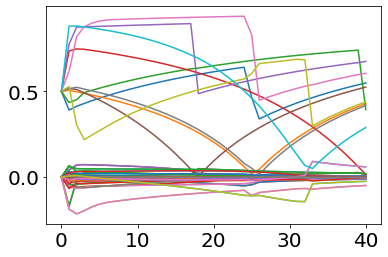

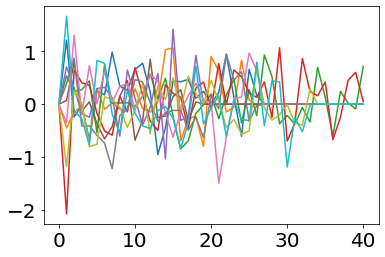

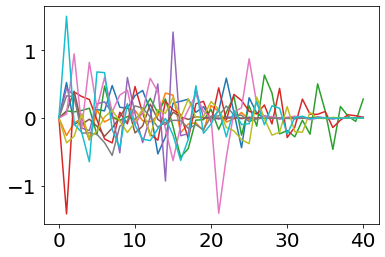

In [28]:
n = 5
prop = 1.0
f_name = f"ukf_agents_{n}_prop_{prop}.pkl"
ks, mus, kmus = aggregate_critique.main(f_name)

## Experiment 2 Kalman Gain

Having explored a case where the ukf works as desired, we present our aggregate case where the ukf fails to try and determine why using the established visualisation.

This time we see very different kalman gain visualistation. In experiment 1 we saw the diagonal elements of the kalman  were constantly non-zero. This is due to a 1-1 correspondance such that each element of the observed state corresponded directly with an element of the latent state. This explicit tracking allowed for 

Loading pickle agg_ukf_agents_5_bin_25.pkl


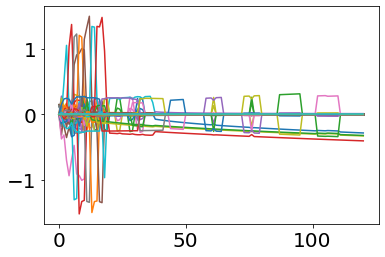

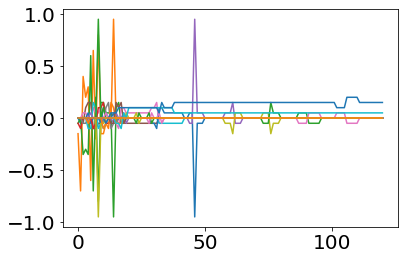

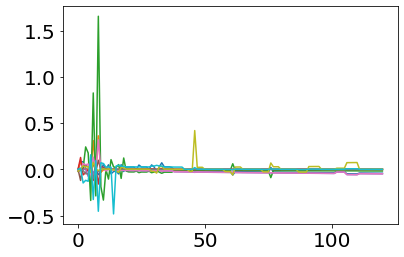

In [29]:
n = 5
bin_size = 25
    
f_name = f"agg_ukf_agents_{n}_bin_{bin_size}.pkl"  
#f_name = f"ukf_agents_{n}_prop_{prop}.pkl"

ks, mus, kmus = aggregate_critique.main(f_name)

In [ ]:
overdispersion
normal error
scaling
noise structure
high dimensional observations




(10, 10)

## High dimensionality

The UKF is known to struggle with high dimensional scenarios. To quote Deng et al. (https://pdfs.semanticscholar.org/16d8/9be63d69ec53cec8f5c39a18a5259df8a3bb.pdf):

"The general UKF may not be stable, especially in a high-dimensional system. The inverse operation makes somelarge elements of the covariance matrix become very small. After a few operations, the elements which are close to zero become zero due to truncation errors. The accumulation and spread of truncation errors usually destroy the positive definiteness essential to a covariance matrix leading to the instability of numerical calculations in the general UKF."

and 

"The standard UKF has an excellent performance in the estimation of general nonlinear systems, but it has a poor performance in tracking mutation parameters and states. When the process noise is imprecise or the measurement noise is time-varying, the accuracy of general UKF would be greatly reduced. Thus, we should improve its ability to track catastrophe parameters and states. The adaptive UKF should also be adapted to the time-varying observation noise and the inaccurate process noise. Furthermore, the adaptive UKF should be stable enough for high-dimension systems."


https://arxiv.org/pdf/1701.05573.pdf pgds
https://www.math.leidenuniv.nl/scripties/MasterGu.pdf spatial kf
https://projecteuclid.org/download/pdfview_1/euclid.bjps/1481619620 spatial enkf for rainfall
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998071/ 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5456165
https://www.jstor.org/stable/pdf/2288936.pdf?refreqid=excelsior%3A741f9261ce1d36aecd81b2e56e6ec76f

paper done

MCMC style
abc style ensemble seems to work well but is basically enkf
likewise could sample points randomly around grid squares using gaussian mixture/hmc/qft

trying to figure out if i can apply ukf to aggregate state space 

currently seems to be a few major problems
gaussian noise - some kind of generalised KF? some kind of glmm/GEE? some further state space e.g. poisson-gamma
sparsity/overdispersion - solve with dimension reduction etc.
lack of spatial/temporal correlations - some augments to filtering do this.



